Para trabajar con datos financieros de Yahoo Finance, primero necesito instalar la biblioteca de yfinance, para eso utilizamos el siguiente comando. Con ella podres descargar cotizaciones de acciones y muchos datos financieros de compañias que cotizan en bolsa.

In [1]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Ejecutamos el siguiente comando exportar o importar archvios en formato excel.  En mi caso lo utilizaré para poder exportar archivos en formato Excel.

In [2]:
! pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


El siguiente comando lo he utilizado para poder ajustar las etiquitas  en gráficos. Me ha sido útil para que las etiquetas no se superpongan.

In [3]:
pip install adjustText

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
import random
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from adjustText import adjust_text
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
## Función para seleccionar una fecha aleatoria que sea el primer día de un mes y calcular la fecha de salida
#def random_date_with_duration(start, end): 
## Crear una lista de todos los primeros días del mes entre start y end
    #all_dates = pd.date_range(start=start, end=end, freq='MS')
## Seleccionar una fecha de entrada aleatoria de la lista
    #start_date_random = random.choice(all_dates) 
## Calcular la fecha de salida (2 años después) 
    #end_date_random = start_date_random + pd.DateOffset(years=2) 
## Asegurarse de que la fecha de salida no esté fuera del rango end
    #if end_date_random > end: 
        #end_date_random = end 
## Convertir fechas a datetime.date
    #start_date_random = start_date_random.date() 
    #end_date_random = end_date_random.date()
    #return start_date_random, end_date_random

Para lo siguiente he seleccionado un conjunto de acciones, de tres sectores princiaples, Tecnológico-Comunicación, Consumo y Salud
He tomado datos, cotizaciones mensuales. Y lo he considerado como rango de fecha desde inicio del 2019 hasta el 2022. No obstante he puesto como fecha de inicio Diciembre de 2018, porque ala ser mensual toma el cierre de dicho mes, y dicho cierre será el inicio de Enero del 2019.
He creado un DataFrame llamado cotizaciones generales, que toma las acciones que aparecen en la lista.

In [6]:
acc_grales= ['GOOG','META','NFLX','DIS','VZ','CMCSA','SPOT','CHTR','NTES','EA','SONY',
             'AAPL','NVDA','MSFT','TSM','AVGO','ORCL','CRM','SAP','ADBE','AMD','IBM','AMZN','HD','MCD',
             'PG','WMT','ABNB','BABA','NKE','SBUX','KO','BUD','DEO','NVO','JNJ','MRK','PFE','SNY']
fecha_inicio = dt.datetime(2018, 12, 1)
fecha_corte =dt.datetime(2020, 1, 1)
end_date = dt.datetime.now()
cotizac_grales = yf.download(acc_grales, start = fecha_inicio, end= end_date ,interval='1mo', rounding=True)['Adj Close']
cotizac_grales.reset_index(inplace=True)
cotizac_grales['Date'] = pd.to_datetime(cotizac_grales['Date']).dt.tz_localize(None).dt.date
cotizac_grales.set_index('Date', inplace=True)

[*********************100%***********************]  39 of 39 completed


In [7]:
# Identificar columnas con valores nulos y pasarlos a lista
columnas_con_nulos = cotizac_grales.columns[cotizac_grales.isnull().any()].tolist() 
print("Columnas con valores nulos:", columnas_con_nulos)

Columnas con valores nulos: ['ABNB']


In [8]:
# Eliminar columnas con datos nulos
cotizac_grales= cotizac_grales.drop(columns=columnas_con_nulos)


Aqui procedo a realizar una variacion porcentual, que será el dataframe principal con el que vamos a trabajar, de ahi podremos calcular las medidas de rendimiento y volatiliad (riesgo)

In [9]:
# Calculo Variacion Porcentual para calcular la Volatilidad - DesvSTD
variac_porcent_gral = cotizac_grales.pct_change(1).dropna()
variac_porcent_gral

Ticker,AAPL,ADBE,AMD,AMZN,AVGO,BABA,BUD,CHTR,CMCSA,CRM,...,PFE,PG,SAP,SBUX,SNY,SONY,SPOT,TSM,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.054951,0.095385,0.322319,0.144341,0.066382,0.229282,0.161513,0.161701,0.080136,0.109563,...,-0.027605,0.049608,0.038936,0.058088,0.000871,0.037960,0.193392,0.019315,-0.020762,0.034544
2019-02-01,0.040513,0.059237,-0.036051,-0.045962,0.026234,0.086283,0.022373,0.041867,0.057215,0.076867,...,0.029984,0.029539,0.035871,0.031110,-0.042356,-0.042286,0.034625,0.037897,0.044650,0.033046
2019-03-01,0.101572,0.015200,0.084573,0.085986,0.092288,-0.003168,0.074377,0.005799,0.033898,-0.032284,...,-0.020130,0.055861,0.077734,0.063569,0.064223,-0.120525,-0.009562,0.048881,0.038682,-0.014995
2019-04-01,0.056422,0.085407,0.082680,0.081873,0.068227,0.017083,0.059172,0.069989,0.088870,0.044079,...,-0.043932,0.023403,0.116056,0.044903,-0.012240,0.218453,-0.021830,0.069905,-0.032644,0.060217
2019-05-01,-0.127598,-0.063440,-0.007962,-0.078688,-0.209803,-0.195636,-0.084713,0.015114,-0.053090,-0.084315,...,0.022479,-0.026769,-0.044861,-0.020761,-0.075504,-0.046771,-0.075053,-0.124902,-0.039924,-0.013720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0.031140,0.041258,0.028239,-0.045352,0.013362,0.056944,0.032605,-0.084747,-0.033227,-0.021280,...,-0.036425,0.073524,0.038327,0.213089,0.085891,0.101016,-0.003082,0.035595,0.048153,0.125201
2024-09-01,0.018645,-0.098588,0.104470,0.043866,0.059400,0.273338,0.078939,-0.067503,0.055499,0.082297,...,-0.002450,0.009675,0.042738,0.037144,0.024351,-0.010251,0.074808,0.011457,0.074866,0.048542
2024-10-01,-0.030420,-0.076673,-0.121953,0.000376,-0.012563,-0.076706,-0.104390,0.010892,0.045586,0.066196,...,-0.022105,-0.046344,0.019817,0.002167,-0.082422,-0.088555,0.044962,0.101196,-0.061963,0.014894


Las medidas de retorno y volatilidad obtenidas se han anualizado para alinearse con las prácticas estándar en finanzas, donde el análisis se realiza comúnmente en términos anuales. Esto permite una comparación más directa y precisa de los datos a lo largo del tiempo, proporcionando una visión clara del desempeño de las inversiones en diferentes contextos económicos.

In [10]:
# Ahora sacar informe por volatilidad y Anualizar, y ordenar por mayor volatilidad
desv_std_anual= np.std(variac_porcent_gral,ddof=1)*np.sqrt(12)

# Calculo Rendmiento Esperado Mensual
rendimiento_esperado_mensual = variac_porcent_gral.mean()
rendimiento_esperado_anual = (1 + rendimiento_esperado_mensual) ** 12 - 1


In [11]:
# Resumen de las acciones con mayor rendimiento en el lapso de tiempo estudiado.
rendimiento_esperado_anual.sort_values(ascending=False).head(10)


Ticker
NVDA    1.057041
AVGO    0.600389
AMD     0.550887
TSM     0.437430
AAPL    0.424777
SPOT    0.420154
META    0.404322
NFLX    0.342818
NVO     0.341673
MSFT    0.323335
dtype: float64

Para ver un data frame resuemn que muestre el rendimiento anual y la volatilidad de cada accion.

In [12]:
resultados = pd.DataFrame({ 'Rendimiento Esperado Anual': rendimiento_esperado_anual, 'Desvío Estándar Anual':desv_std_anual}).sort_values(by='Rendimiento Esperado Anual', ascending=False)


In [13]:
resultados

,Rendimiento Esperado Anual,Desvío Estándar Anual
Ticker,,
NVDA,1.057041,0.482462
AVGO,0.600389,0.367471
AMD,0.550887,0.510965
TSM,0.437430,0.354437
AAPL,0.424777,0.283738
SPOT,0.420154,0.484686
META,0.404322,0.399474
NFLX,0.342818,0.404545
NVO,0.341673,0.211323


Clasificar las acciones según su nivel de volatilidad, diferenciándolas entre las de mayor y menor volatilidad, lo que me permitirá graficarlas y mantenerlas mejor organizadas en el gráfico.

In [14]:
# Clasificar las acciones 
acciones_volatiles = desv_std_anual[desv_std_anual > 0.25].index.tolist()
acciones_conservadoras = desv_std_anual[desv_std_anual <= 0.25].index.tolist()

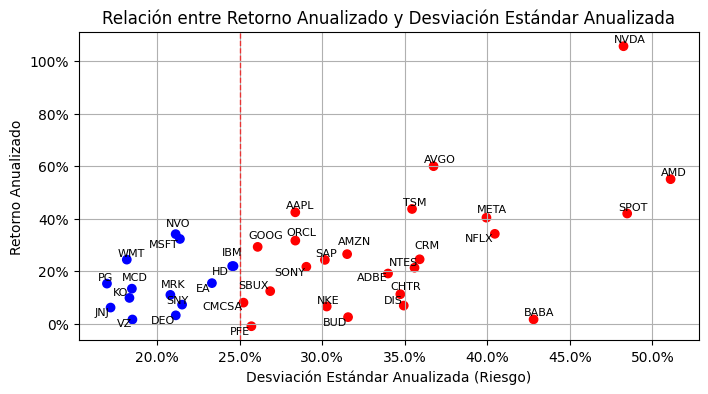

In [15]:
# Crear listas de colores según la clasificación de volatilidad
colors = ['red' if accion in acciones_volatiles else 'blue' for accion in desv_std_anual.index]
# Crear el scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(desv_std_anual, rendimiento_esperado_anual, color=colors)

# Añadir etiquetas de texto a cada punto
texts = []
for i, accion in enumerate(desv_std_anual.index): 
    texts.append(plt.text(desv_std_anual[i], rendimiento_esperado_anual[i], accion, fontsize=8, ha='right'))

adjust_text(texts)

# Configurar el gráfico
plt.title('Relación entre Retorno Anualizado y Desviación Estándar Anualizada')
plt.xlabel('Desviación Estándar Anualizada (Riesgo)')
plt.ylabel('Retorno Anualizado')
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.axvline(x=0.25, color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.grid(True)
plt.show()

Era poner un ejemplo en valores monetarios, con un ejemplo de 2000 euros, como era el comportamiento de principio a fin en cada accion.

In [16]:
# Calcular la variación porcentual y el capital final
capital_inicial = 2000
capital_acumulado = pd.DataFrame(index=variac_porcent_gral.index)
for ticker in variac_porcent_gral.columns:
    capital_acumulado[ticker]=round(capital_inicial*(1+variac_porcent_gral[ticker]).cumprod(),2)

capital_acumulado

,AAPL,ADBE,AMD,AMZN,AVGO,BABA,BUD,CHTR,CMCSA,CRM,...,PFE,PG,SAP,SBUX,SNY,SONY,SPOT,TSM,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2109.90,2190.77,2644.64,2288.68,2132.76,2458.56,2323.03,2323.40,2160.27,2219.13,...,1944.79,2099.22,2077.87,2116.18,2001.74,2075.92,2386.78,2038.63,1958.48,2069.09
2019-02-01,2195.38,2320.54,2549.30,2183.49,2188.72,2670.70,2375.00,2420.68,2283.87,2389.70,...,2003.10,2161.23,2152.41,2182.01,1916.96,1988.14,2469.43,2115.89,2045.92,2137.46
2019-03-01,2418.37,2355.82,2764.90,2371.24,2390.71,2662.23,2551.64,2434.71,2361.29,2312.56,...,1962.78,2281.95,2319.72,2320.72,2040.07,1748.52,2445.81,2219.31,2125.06,2105.41
2019-04-01,2554.82,2557.02,2993.50,2565.38,2553.82,2707.71,2702.63,2605.12,2571.14,2414.49,...,1876.55,2335.36,2588.94,2424.93,2015.10,2130.49,2392.42,2374.45,2055.69,2232.19
2019-05-01,2228.83,2394.80,2969.66,2363.52,2018.02,2177.99,2473.68,2644.49,2434.63,2210.91,...,1918.73,2272.84,2472.80,2374.58,1862.95,2030.84,2212.86,2077.88,1973.62,2201.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,12130.61,5077.88,16095.34,4753.66,15390.23,1259.20,2021.05,2439.13,2667.57,3703.43,...,1772.33,4316.38,4888.42,3288.86,3267.13,4628.71,6041.94,10658.57,2009.77,5472.93
2024-09-01,12356.78,4577.26,17776.81,4962.18,16304.41,1603.38,2180.59,2274.49,2815.62,4008.21,...,1767.99,4358.14,5097.34,3411.02,3346.69,4581.26,6493.92,10780.69,2160.23,5738.60
2024-10-01,11980.89,4226.31,15608.88,4964.05,16099.57,1480.40,1952.96,2299.26,2943.97,4273.54,...,1728.91,4156.16,5198.35,3418.41,3070.85,4175.56,6785.90,11871.65,2026.38,5824.07


Veeerr...!! modificar...!!

In [17]:

# Definir fechas de entrada y salida
fecha_entrada = dt.datetime(2022, 1, 1)
fecha_salida = dt.datetime(2023, 1, 1)

# Inicializar DataFrame para almacenar los resultados
resultados_tests = pd.DataFrame()

# Número de tests a realizar
num_tests = 5

for i in range(1, num_tests + 1):
    # Seleccionar 3 acciones aleatoriamente de las acciones volátiles
    acciones_aleatorias = random.sample(acciones_volatiles, 3)

    # Calcular precios de entrada y salida
    precio_entrada = cotizac_grales.loc[fecha_entrada.date(), acciones_aleatorias]
    precio_salida = cotizac_grales.loc[fecha_salida.date(), acciones_aleatorias]

    # Inicializar DataFrame para los resultados del test
    resultados_test = pd.DataFrame(index=acciones_aleatorias)
    resultados_test['Capital Inicial'] = 5000  # Capital inicial arbitrario
    resultados_test['Precio Entrada'] = precio_entrada
    resultados_test['Precio Salida'] = precio_salida
    resultados_test['Capital Final'] = round(resultados_test['Capital Inicial'] * (precio_salida / precio_entrada), 0)
    resultados_test['Variac $'] = round((resultados_test['Capital Final'] - resultados_test['Capital Inicial']), 0)
    resultados_test['Variac %'] = (resultados_test['Variac $'] / resultados_test['Capital Inicial']) * 100
    resultados_test['Fecha Entrada'] = fecha_entrada
    resultados_test['Fecha Salida'] = fecha_salida

    # Añadir los resultados del test al DataFrame general
    resultados_tests = pd.concat([resultados_tests, resultados_test], keys=[f'Test{i}'])

# Resetear índice para que se vea mejor
resultados_tests.reset_index(level=1, drop=True, inplace=True)
resultados_tests.reset_index(inplace=True)

print(resultados_tests)


Empty DataFrame
Columns: [level_0, level_1, level_2, level_3, level_4]
Index: []


En lo siguiente he seleccionado una fecha en particular donde hubo un impacto negativo en los precios de las acciones, y me parecia adecuado de cara al analisis de Riesgo - Retorno, evaluar desempeño de diferentes carteras Volatiles y diferentes Carteras Conservadoras.
Ejemplo Enero del 2022 hasta Enero del 2023. Cada seleccion sera de 3 aciones de la cartera Volatiles


El paso siguiente es armar un supuesto, con 10 acciones en cartera para ir demostrando como vamos disminuyendo el riesgo al ir incorporando uno a uno al Portfolio de inversion (Cartera de acciones)
Para ver mas claramente el efecto de la diversificacion vamos a comenzar por la accion más volatil de todas, luego agregamos una de menor volatilidad y vamos alternanto volatiles con conservadoras.

El paso siguiente es armar un supuesto, con 14 acciones en cartera para ir demostrando como vamos disminuyendo el riesgo. Para demostrarlo de la forma más clara posible, comenzamos por la accion más volatil y luego vamos alternando con acción conservadora, y así sucesivamente vamos alternando una y otra. Hasta completar el Portofolio de 14 acciones (7 volatiles - 7 conservadoras)

In [18]:
acciones_cartera= ['AMD','PG', 'NVDA','JNJ','SPOT','VZ','KO', 'BABA','VZ','MCD', 'NFLX','DEO', 'META','MRK']

In [19]:
cant_acciones = 14
proporcion = [1/cant_acciones]*cant_acciones

Calculo de la varianza del Portfolio para luego calcular el Desvio Standard (como medida de riesgo del mismo)
Para ello aplicammos la siguiente funcion de numpay.

In [20]:
portfolios = []
for nro in range(1,cant_acciones+1):
    portfolios.append(acciones_cartera[0:nro])
portfolios

[['AMD'],
 ['AMD', 'PG'],
 ['AMD', 'PG', 'NVDA'],
 ['AMD', 'PG', 'NVDA', 'JNJ'],
 ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT'],
 ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ'],
 ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO'],
 ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO', 'BABA'],
 ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO', 'BABA', 'VZ'],
 ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO', 'BABA', 'VZ', 'MCD'],
 ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO', 'BABA', 'VZ', 'MCD', 'NFLX'],
 ['AMD',
  'PG',
  'NVDA',
  'JNJ',
  'SPOT',
  'VZ',
  'KO',
  'BABA',
  'VZ',
  'MCD',
  'NFLX',
  'DEO'],
 ['AMD',
  'PG',
  'NVDA',
  'JNJ',
  'SPOT',
  'VZ',
  'KO',
  'BABA',
  'VZ',
  'MCD',
  'NFLX',
  'DEO',
  'META'],
 ['AMD',
  'PG',
  'NVDA',
  'JNJ',
  'SPOT',
  'VZ',
  'KO',
  'BABA',
  'VZ',
  'MCD',
  'NFLX',
  'DEO',
  'META',
  'MRK']]

In [21]:
# Ir guardando cada portafolio a medida que voy incorporando una accion
riesgo_portofolio = []

for nro_port in portfolios:
    df = variac_porcent_gral[nro_port]

    nro_acciones = len(df.columns)
    proporcion = [1/nro_acciones] * nro_acciones
    matriz_covarianza = df.cov() * 12  

    varianza_portfolio = np.dot(np.transpose(proporcion), np.dot(matriz_covarianza, proporcion))
    desv_std_portfolio_anual = round(np.sqrt(varianza_portfolio),4)

    riesgo_portofolio.append(desv_std_portfolio_anual) 



In [22]:
riesgo_portofolio

[np.float64(0.511),
 np.float64(0.2841),
 np.float64(0.3164),
 np.float64(0.2489),
 np.float64(0.2615),
 np.float64(0.2314),
 np.float64(0.207),
 np.float64(0.2043),
 np.float64(0.1927),
 np.float64(0.1813),
 np.float64(0.1882),
 np.float64(0.1804),
 np.float64(0.1876),
 np.float64(0.179)]

In [23]:
riesgo_portfolio_final = riesgo_portofolio[-1]
riesgo_portfolio_final

np.float64(0.179)

In [24]:
# DESVIO STD DEL PORTFOLIO, si la matriz de covarianza la pase a anual, no tengo que multiplicarla por raiz de 12 pq ya esta en anual..!


In [25]:
riesgo_individual = np.std(variac_porcent_gral[acciones_cartera],ddof=1)*np.sqrt(12)
riesgo_individual.sort_values(ascending=False)

Ticker
AMD     0.510965
SPOT    0.484686
NVDA    0.482462
BABA    0.428014
NFLX    0.404545
META    0.399474
DEO     0.211388
MRK     0.208118
VZ      0.185144
VZ      0.185144
MCD     0.184825
KO      0.183348
JNJ     0.171918
PG      0.169728
dtype: float64

In [26]:
retorno_portfolio=variac_porcent_gral[acciones_cartera].mean()
retorno_portfolio

Ticker
AMD     0.037246
PG      0.011960
NVDA    0.061949
JNJ     0.005034
SPOT    0.029662
VZ      0.001382
KO      0.007885
BABA    0.001418
VZ      0.001382
MCD     0.010540
NFLX    0.024868
DEO     0.002671
META    0.028700
MRK     0.008767
dtype: float64

In [27]:
rendimiento_esperado_anual[acciones_cartera]

Ticker
AMD     0.550887
PG      0.153349
NVDA    1.057041
JNJ     0.062107
SPOT    0.420154
VZ      0.016710
KO      0.098827
BABA    0.017149
VZ      0.016710
MCD     0.134079
NFLX    0.342818
DEO     0.032524
META    0.404322
MRK     0.110428
dtype: float64

In [28]:
retorno_esperado_portfolio = (proporcion*rendimiento_esperado_anual[acciones_cartera]).sum()
retorno_esperado_portfolio

np.float64(0.24407887176504686)

In [29]:
risk_portfolio = pd.DataFrame(riesgo_portofolio)

In [30]:
risk_portfolio = pd.DataFrame(riesgo_portofolio, columns=['Riesgo Total'])

In [31]:
risk_portfolio

,Riesgo Total
0,0.5110
1,0.2841
2,0.3164
3,0.2489
4,0.2615
5,0.2314
6,0.2070
7,0.2043
8,0.1927
9,0.1813


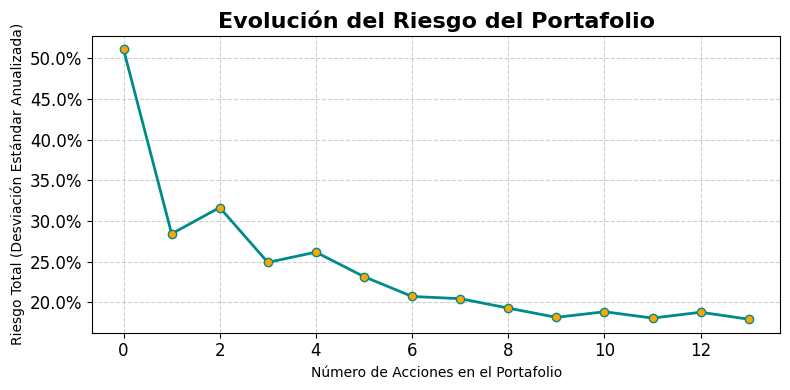

In [32]:

plt.figure(figsize=(8, 4)) 
plt.plot(risk_portfolio, color='darkcyan', linestyle='-', linewidth=2, marker='o', markerfacecolor='orange') 
plt.title('Evolución del Riesgo del Portafolio', fontsize=16, weight='bold') 
plt.xlabel('Número de Acciones en el Portafolio', fontsize=10) 
plt.ylabel('Riesgo Total (Desviación Estándar Anualizada)', fontsize=10) 
plt.grid(True, linestyle='--', alpha=0.6) 
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.tight_layout() 
plt.show()

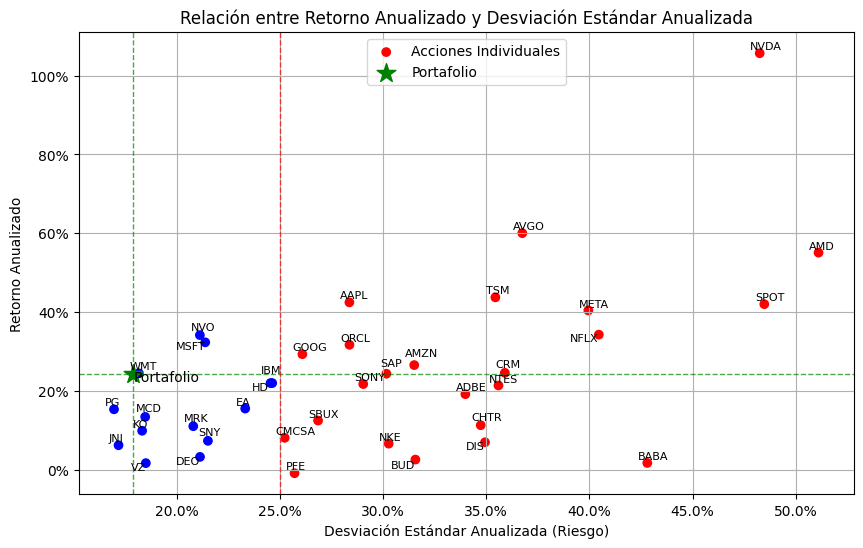

In [33]:


# Crear listas de colores según la clasificación de volatilidad
colors = ['red' if accion in acciones_volatiles else 'blue' for accion in desv_std_anual.index]

# Crear el scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(desv_std_anual, rendimiento_esperado_anual, color=colors, label='Acciones Individuales')

# Añadir etiquetas de texto a cada punto
texts = []
for i, accion in enumerate(desv_std_anual.index): 
    texts.append(plt.text(desv_std_anual[i], rendimiento_esperado_anual[i], accion, fontsize=8, ha='right'))

adjust_text(texts)

# Añadir el punto del portafolio
plt.scatter(desv_std_portfolio_anual, retorno_esperado_portfolio, color='green', marker='*', s=200, label='Portafolio')

# Añadir etiquetas para el punto del portafolio
plt.text(desv_std_portfolio_anual, retorno_esperado_portfolio - 0.02, 'Portafolio', fontsize=10, ha='left')  # Ubicar la etiqueta más abajo

# Añadir líneas punteadas que cruzan el punto del portafolio
plt.axhline(y=retorno_esperado_portfolio, color='green', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(x=desv_std_portfolio_anual, color='green', linestyle='--', linewidth=1, alpha=0.7)

# Configurar el gráfico
plt.title('Relación entre Retorno Anualizado y Desviación Estándar Anualizada')
plt.xlabel('Desviación Estándar Anualizada (Riesgo)')
plt.ylabel('Retorno Anualizado')
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.axvline(x=0.25, color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.grid(True)
plt.legend()
plt.show()


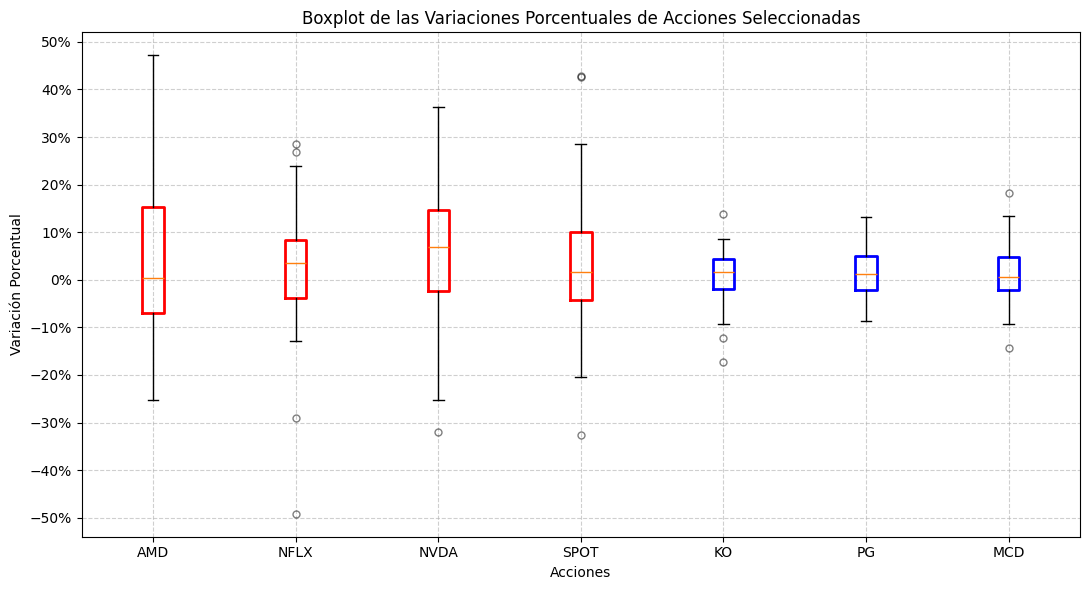

In [34]:
# Filtrar las variaciones porcentuales solo para 'NFLX' y 'KO'
variac_porcent_gral_filtrado = variac_porcent_gral[['AMD','NFLX','NVDA','SPOT', 'KO','PG','MCD']]

# Crear el boxplot
plt.figure(figsize=(11,6))

# Colores específicos para cada conjunto de acciones
colors = {'AMD': 'red', 'NFLX': 'red', 'NVDA': 'red', 'SPOT': 'red', 
          'KO': 'blue', 'PG': 'blue', 'MCD': 'blue'}

# Crear boxplots individuales para cada grupo de acciones con colores diferentes
boxprops = dict(linestyle='-', linewidth=2)
flierprops = dict(marker='o', color='black', markersize=5, alpha=0.5)

for action in variac_porcent_gral_filtrado.columns:
    plt.boxplot(variac_porcent_gral_filtrado[action], positions=[list(variac_porcent_gral_filtrado.columns).index(action)], 
                boxprops=dict(color=colors[action], **boxprops), flierprops=flierprops)

# Configurar el gráfico
plt.xticks(range(len(variac_porcent_gral_filtrado.columns)), variac_porcent_gral_filtrado.columns)
plt.title('Boxplot de las Variaciones Porcentuales de Acciones Seleccionadas')
plt.xlabel('Acciones')
plt.ylabel('Variación Porcentual')
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar las escalas porcentuales en el eje y
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(0.1))  # Escala cada 10%

plt.tight_layout()
plt.show()



In [35]:

# Definir lista de acciones y rango de fechas
sector_tec = ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO', 'BABA', 'VZ', 'MCD', 'NFLX', 'DEO', 'META', 'MRK']
fecha_inicio = dt.datetime(2018, 12, 1)
end_date = dt.datetime(2024, 11, 1)

# Descargar los datos de cotización
cotizac_grales = yf.download(sector_tec, start=fecha_inicio, end=end_date, interval='1mo', rounding=True)['Adj Close']
cotizac_grales.reset_index(inplace=True)
cotizac_grales['Date'] = pd.to_datetime(cotizac_grales['Date']).dt.tz_localize(None).dt.date
cotizac_grales.set_index('Date', inplace=True)

# Calculo Variacion Porcentual para calcular la Volatilidad - DesvSTD
variac_porcent_gral = cotizac_grales.pct_change(1).dropna()

# Filtrar los datos de las acciones del portafolio
acciones_portafolio = ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO', 'BABA', 'VZ', 'MCD', 'NFLX', 'DEO', 'META', 'MRK']
variac_porcent_portafolio = variac_porcent_gral[acciones_portafolio]

# Calcular la matriz de covarianza anualizada
matriz_covarianza_anual = variac_porcent_portafolio.cov() * 12

# Definir las proporciones de cada acción en el portafolio (todas iguales)
proporciones = np.array([1/len(acciones_portafolio)] * len(acciones_portafolio))

# Calcular el rendimiento esperado mensual y anualizado del portafolio
rendimiento_esperado_mensual = variac_porcent_portafolio.mean()
rendimiento_esperado_anual = (1 + rendimiento_esperado_mensual) ** 12 - 1

# Calcular el rendimiento esperado del portafolio
rendimiento_esperado_portafolio = np.dot(proporciones, rendimiento_esperado_anual)

# Calcular la varianza del portafolio
varianza_portafolio = np.dot(proporciones.T, np.dot(matriz_covarianza_anual, proporciones))

# Calcular el desvío estándar anualizado del portafolio
desv_std_portfolio_anual = np.sqrt(varianza_portafolio)

# Imprimir los resultados
print(f"Rendimiento Esperado Anual del Portafolio: {rendimiento_esperado_portafolio:.4f}")
print(f"Desvío Estándar Anualizado del Portafolio: {desv_std_portfolio_anual:.4f}")


[*********************100%***********************]  13 of 13 completed

Rendimiento Esperado Anual del Portafolio: 0.2477
Desvío Estándar Anualizado del Portafolio: 0.1811


Testeo de la Cartera Seleccionada, de como fue su comportamiento, su retorno y desvio std en año 2022 que fue año de mayor volatilidad despues de la crisis hipotecaria sucedida en año 2008.

In [36]:


# Definir lista de acciones y rango de fechas
sector_tec = ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO', 'BABA', 'MCD', 'NFLX', 'DEO', 'META', 'MRK']
fecha_inicio = dt.datetime(2018, 12, 1)
end_date = dt.datetime(2024, 11, 1)

# Descargar los datos de cotización
cotizac_grales = yf.download(sector_tec, start=fecha_inicio, end=end_date, interval='1mo', rounding=True)['Adj Close']
cotizac_grales.reset_index(inplace=True)
cotizac_grales['Date'] = pd.to_datetime(cotizac_grales['Date']).dt.tz_localize(None).dt.date
cotizac_grales.set_index('Date', inplace=True)
variac_porcent_gral = cotizac_grales.pct_change(1).dropna()
acciones_portafolio = ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO', 'BABA', 'MCD', 'NFLX', 'DEO', 'META', 'MRK']
variac_porcent_portafolio = variac_porcent_gral[acciones_portafolio]
variac_porcent_portafolio.index = pd.to_datetime(variac_porcent_portafolio.index)

# Filtrar datos para el año 2022
variac_porcent_2022 = variac_porcent_portafolio.loc[variac_porcent_portafolio.index.year == 2022]

# matriz de covarianza 2022
matriz_covarianza_2022 = variac_porcent_2022.cov() * 12

rendimiento_esperado_mensual_2022 = variac_porcent_2022.mean()
rendimiento_esperado_anual_2022 = (1 + rendimiento_esperado_mensual_2022) ** 12 - 1

# Definir las proporciones de cada acción en el portafolio (todas iguales)
proporciones = np.array([1/len(acciones_portafolio)] * len(acciones_portafolio))

# Calcular el rendimiento esperado del portafolio para 2022
rendimiento_esperado_portafolio_2022 = np.dot(proporciones, rendimiento_esperado_anual_2022)

varianza_portafolio_2022 = np.dot(proporciones.T, np.dot(matriz_covarianza_2022, proporciones))

desv_std_portfolio_anual_2022 = np.sqrt(varianza_portafolio_2022)

# Imprimir los resultados
print(f"Rendimiento Esperado Anual del Portafolio en 2022: {rendimiento_esperado_portafolio_2022:.4f}")
print(f"Desvío Estándar Anualizado del Portafolio en 2022: {desv_std_portfolio_anual_2022:.4f}")


[*********************100%***********************]  13 of 13 completed


Rendimiento Esperado Anual del Portafolio en 2022: -0.1611
Desvío Estándar Anualizado del Portafolio en 2022: 0.2434


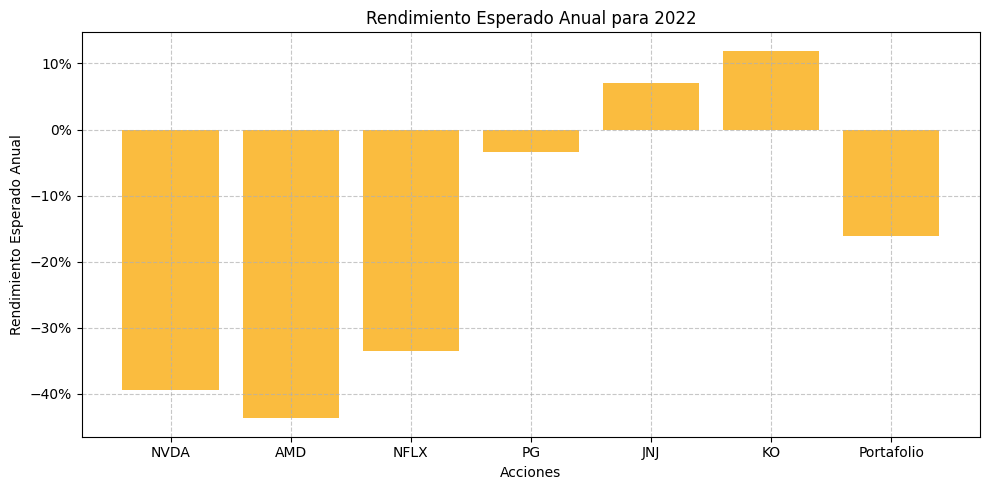

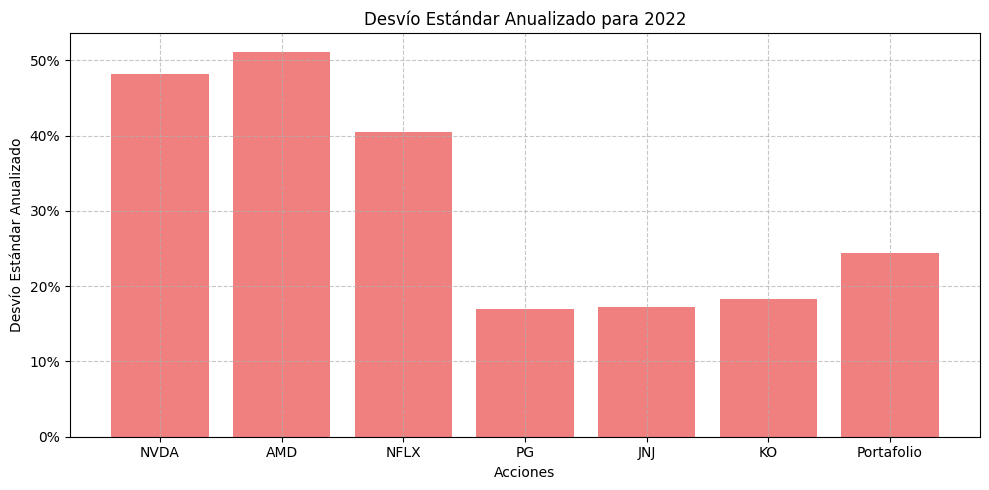

In [39]:

# Datos de rendimiento esperado anual para 2022 de las acciones y el portafolio
rendimiento_esperado_acciones_2022 = rendimiento_esperado_anual_2022[['NVDA', 'AMD', 'NFLX', 'PG', 'JNJ', 'KO']]
nombres_acciones = ['NVDA', 'AMD', 'NFLX', 'PG', 'JNJ', 'KO']
rendimientos_anuales_2022 = rendimiento_esperado_acciones_2022.tolist() + [rendimiento_esperado_portafolio_2022]
nombres_acciones.append('Portafolio')

# Datos de desvío estándar anual para 2022 de las acciones y el portafolio
desv_std_acciones_2022 = desv_std_anual[['NVDA', 'AMD', 'NFLX', 'PG', 'JNJ', 'KO']]
desvios_std_anuales_2022 = desv_std_acciones_2022.tolist() + [desv_std_portfolio_anual_2022]

# Crear gráfico de barras para el rendimiento anual esperado
plt.figure(figsize=(10, 5))
plt.bar(nombres_acciones, rendimientos_anuales_2022, color='#FABC3F')
plt.title('Rendimiento Esperado Anual para 2022')
plt.xlabel('Acciones')
plt.ylabel('Rendimiento Esperado Anual')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.tight_layout()
plt.show()

# Crear gráfico de barras para el desvío estándar anualizado
plt.figure(figsize=(10, 5))
plt.bar(nombres_acciones, desvios_std_anuales_2022, color='lightcoral')
plt.title('Desvío Estándar Anualizado para 2022')
plt.xlabel('Acciones')
plt.ylabel('Desvío Estándar Anualizado')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.tight_layout()
plt.show()


In [ ]:

# Definir lista de acciones y rango de fechas
acciones_portafolio = ['AMD', 'PG', 'NVDA', 'JNJ', 'SPOT', 'VZ', 'KO', 'BABA', 'MCD', 'NFLX', 'DEO', 'META', 'MRK']
fecha_inicio = dt.datetime(2018, 12, 1)
end_date = dt.datetime(2024, 11, 1)

# Descargar los datos de cotización
cotizac_grales = yf.download(acciones_portafolio, start=fecha_inicio, end=end_date, interval='1mo', rounding=True)['Adj Close']
cotizac_grales.reset_index(inplace=True)
cotizac_grales['Date'] = pd.to_datetime(cotizac_grales['Date']).dt.tz_localize(None).dt.date
cotizac_grales.set_index('Date', inplace=True)

# Calculo Variacion Porcentual para calcular la Volatilidad - DesvSTD
variac_porcent_gral = cotizac_grales.pct_change(1).dropna()

# Asegurarnos de que el índice de fecha esté en el formato correcto y sea de tipo datetime
variac_porcent_gral.index = pd.to_datetime(variac_porcent_gral.index)

# Definir las proporciones de cada acción en el portafolio (todas iguales)
proporciones = np.array([1/len(acciones_portafolio)] * len(acciones_portafolio))

# Inicializar listas para los resultados
años = [2019, 2021, 2022, 2023, 2024]
rendimientos_anuales = []
desvios_std_anuales = []

for año in años:
    # Filtrar datos para el año específico
    variac_porcent_año = variac_porcent_gral.loc[variac_porcent_gral.index.year == año]

    # Calcular la matriz de covarianza anualizada para el año
    matriz_covarianza_año = variac_porcent_año.cov() * 12

    # Calcular rendimiento esperado mensual y anualizado para el año
    rendimiento_esperado_mensual_año = variac_porcent_año.mean()
    rendimiento_esperado_anual_año = (1 + rendimiento_esperado_mensual_año) ** 12 - 1

    # Calcular el rendimiento esperado del portafolio para el año
    rendimiento_esperado_portafolio_año = np.dot(proporciones, rendimiento_esperado_anual_año)

    # Calcular la varianza del portafolio para el año
    varianza_portafolio_año = np.dot(proporciones.T, np.dot(matriz_covarianza_año, proporciones))

    # Calcular el desvío estándar anualizado del portafolio para el año
    desv_std_portfolio_anual_año = np.sqrt(varianza_portafolio_año)

    # Almacenar los resultados
    rendimientos_anuales.append(rendimiento_esperado_portafolio_año)
    desvios_std_anuales.append(desv_std_portfolio_año)

# Crear DataFrame resumen
resumen = pd.DataFrame({
    'Año': años,
    'Rendimiento Esperado Anual': rendimientos_anuales,
    'Desvío Estándar Anualizado': desvios_std_anuales
})

# Imprimir el resumen
print(resumen)


[*********************100%***********************]  5 of 5 completed


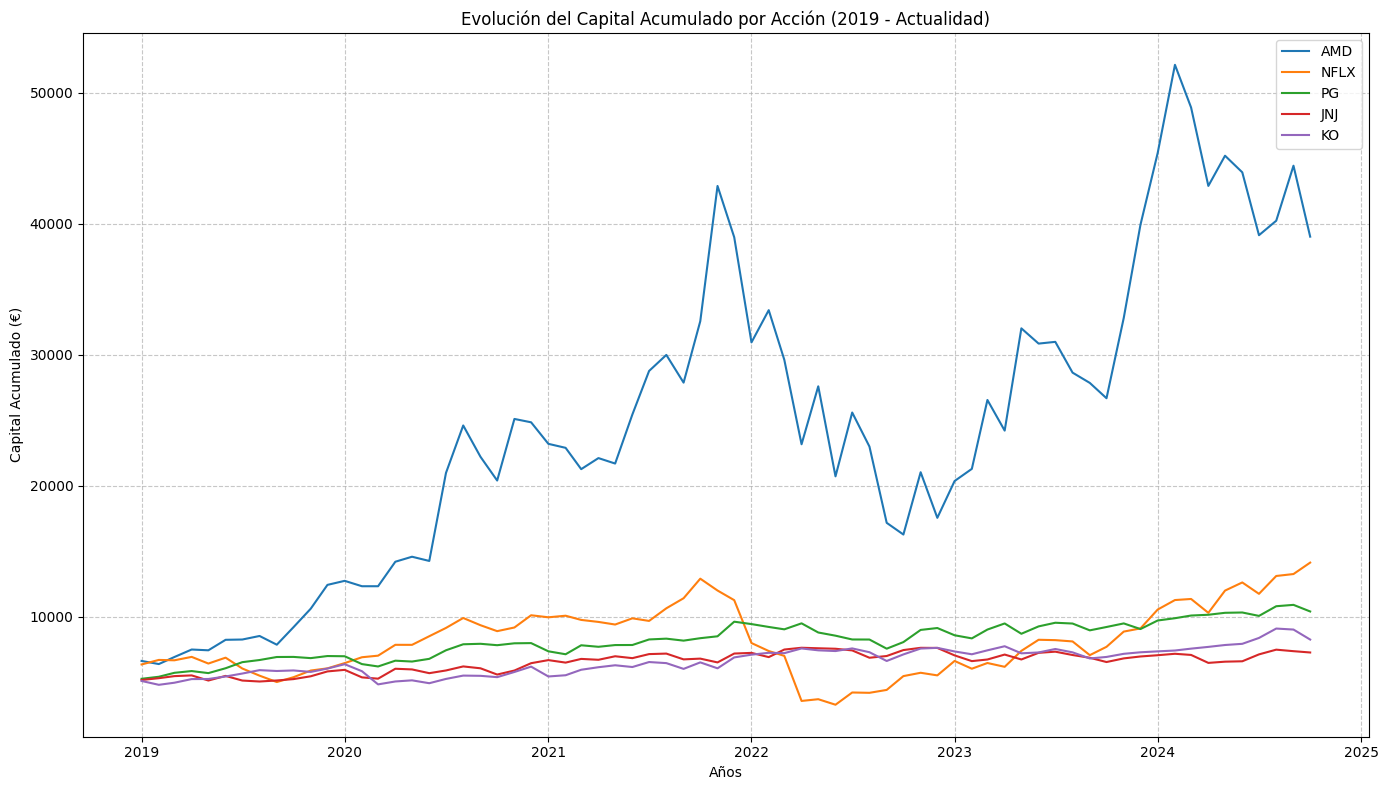

In [41]:

# Definir lista de acciones y rango de fechas
acciones = ['AMD', 'NFLX', 'PG', 'JNJ', 'KO']
fecha_inicio = dt.datetime(2018, 12, 1)
end_date = dt.datetime(2024, 11, 1)
capital_inicial = 5000

# Descargar los datos de cotización
cotizac_grales = yf.download(acciones, start=fecha_inicio, end=end_date, interval='1mo', rounding=True)['Adj Close']
cotizac_grales.reset_index(inplace=True)
cotizac_grales['Date'] = pd.to_datetime(cotizac_grales['Date']).dt.tz_localize(None).dt.date
cotizac_grales.set_index('Date', inplace=True)

# Calcular la variación porcentual para cada acción
variac_porcent_gral = cotizac_grales.pct_change(1).dropna()

# Calcular el capital acumulado para cada acción
capital_acumulado = pd.DataFrame(index=variac_porcent_gral.index)
for ticker in variac_porcent_gral.columns:
    capital_acumulado[ticker] = round(capital_inicial * (1 + variac_porcent_gral[ticker]).cumprod(), 2)

# Crear gráfico de líneas para mostrar la evolución del capital
plt.figure(figsize=(14, 8))
for ticker in acciones:
    plt.plot(capital_acumulado.index, capital_acumulado[ticker], label=ticker)
plt.title('Evolución del Capital Acumulado por Acción (2019 - Actualidad)')
plt.xlabel('Años')
plt.ylabel('Capital Acumulado (€)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


[*********************100%***********************]  5 of 5 completed


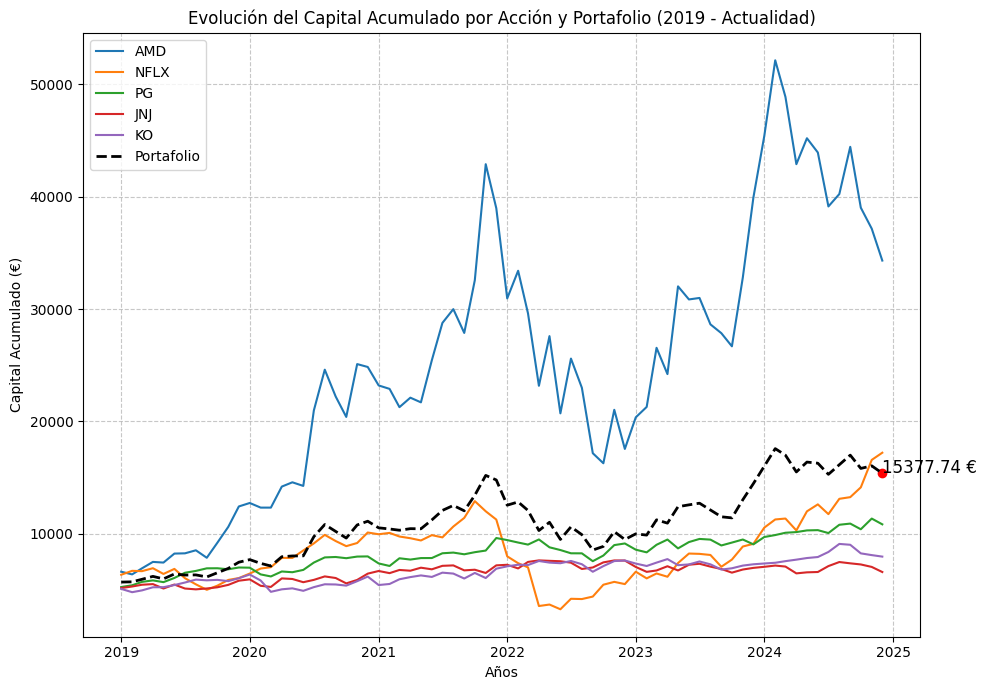

In [ ]:

# Definir lista de acciones y rango de fechas
acciones = ['AMD', 'NFLX', 'PG', 'JNJ', 'KO']
fecha_inicio = dt.datetime(2018, 12, 1)
end_date = dt.datetime(2024, 11, 1)
capital_inicial = 5000

# Descargar los datos de cotización
cotizac_grales = yf.download(acciones, start=fecha_inicio, end=end_date, interval='1mo', rounding=True)['Adj Close']
cotizac_grales.reset_index(inplace=True)
cotizac_grales['Date'] = pd.to_datetime(cotizac_grales['Date']).dt.tz_localize(None).dt.date
cotizac_grales.set_index('Date', inplace=True)

# Calcular la variación porcentual para cada acción
variac_porcent_gral = cotizac_grales.pct_change(1).dropna()

# Calcular el capital acumulado para cada acción
capital_acumulado = pd.DataFrame(index=variac_porcent_gral.index)
for ticker in variac_porcent_gral.columns:
    capital_acumulado[ticker] = round(capital_inicial * (1 + variac_porcent_gral[ticker]).cumprod(), 2)

# Calcular el capital acumulado del portafolio
proporciones = np.array([1/len(acciones)] * len(acciones))
capital_portafolio = (capital_acumulado * proporciones).sum(axis=1)

# Obtener el importe final del portafolio
importe_final_portafolio = capital_portafolio.iloc[-1]

# Crear gráfico de líneas para mostrar la evolución del capital
plt.figure(figsize=(10, 7))
for ticker in acciones:
    plt.plot(capital_acumulado.index, capital_acumulado[ticker], label=ticker)
plt.plot(capital_portafolio.index, capital_portafolio, label='Portafolio', linewidth=2, linestyle='--', color='black')

# Añadir marcador con el importe final del portafolio
plt.scatter(capital_portafolio.index[-1], capital_portafolio[-1], color='red')
plt.text(capital_portafolio.index[-1], capital_portafolio[-1], f'{importe_final_portafolio:.2f} €', fontsize=12, ha='left')

plt.title('Evolución del Capital Acumulado por Acción y Portafolio (2019 - Actualidad)')
plt.xlabel('Años')
plt.ylabel('Capital Acumulado (€)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
